In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
import dgl
import torch

In [19]:
n_nodes = 68
df_distance = pd.read_csv("grid_graph.csv")
sp_mx = coo_matrix(
    (df_distance["cost"].values, 
    (
        df_distance["from"].values, 
        df_distance["to"].values
    )), shape=(n_nodes, n_nodes)
)

G = dgl.from_scipy(sp_mx)
G = dgl.add_self_loop(G)

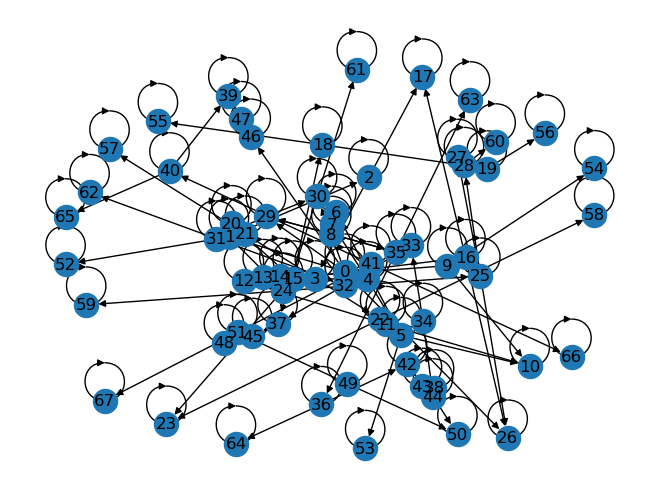

In [20]:
import networkx as nx
nx.draw(dgl.to_networkx(G), with_labels = True)

In [41]:
dgl.distributed.partition_graph(G, graph_name='m_graph', num_parts=4, out_path='curr_dir')

Converting to homogeneous graph takes 0.001s, peak mem: 9.347 GB
Convert a graph into a bidirected graph: 0.000 seconds, peak memory: 9.347 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 9.347 GB
Metis partitioning: 0.000 seconds, peak memory: 9.347 GB
Assigning nodes to METIS partitions takes 0.001s, peak mem: 9.347 GB
Reshuffle nodes and edges: 0.001 seconds
Split the graph: 0.000 seconds
Construct subgraphs: 0.004 seconds
Splitting the graph into partitions takes 0.005s, peak mem: 9.347 GB
part 0 has 21 nodes and 17 are inside the partition
part 0 has 39 edges and 38 are inside the partition
part 1 has 25 nodes and 17 are inside the partition
part 1 has 45 edges and 41 are inside the partition
part 2 has 25 nodes and 17 are inside the partition
part 2 has 44 edges and 37 are inside the partition
part 3 has 23 nodes and 17 are inside the partition
part 3 has 40 edges and 38 are inside the partition
Save partitions: 0.079 seconds, peak memory: 9.347 GB
There are 15

[13:38:22] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 68 nodes and 240 edges into 4 parts and get 15 edge cuts


In [40]:

dgl.distributed.initialize(ip_config='ip_config.txt')
g = dgl.distributed.DistGraph('m_graph')

AssertionError: When running in the standalone model, the partition config file is required

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_ddp = True if torch.cuda.is_available() else False
size = 1

sampler = dgl.dataloading.NeighborSampler([4, 4])
print("[INFO] Device:", device)
graphloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DataLoader.
    graph=G,  # The graph
    indices=range(n_nodes),  # The node IDs to iterate over in minibatches
    graph_sampler=sampler,  # The neighbor sampler
    device=device,  # Put the sampled MFGs on CPU or GPU
    use_ddp=use_ddp,  # Make it work with distributed data parallel
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=10,  # Per-device batch size.
    # The effective batch size is this number times the number of GPUs.
    shuffle=False,  # Whether to shuffle the nodes for every epoch
    drop_last=False,  # Whether to drop the last incomplete batch
    num_workers=0,  # Number of sampler processes
)

[INFO] Device: cpu


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Graph(num_nodes=10, num_edges=19,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


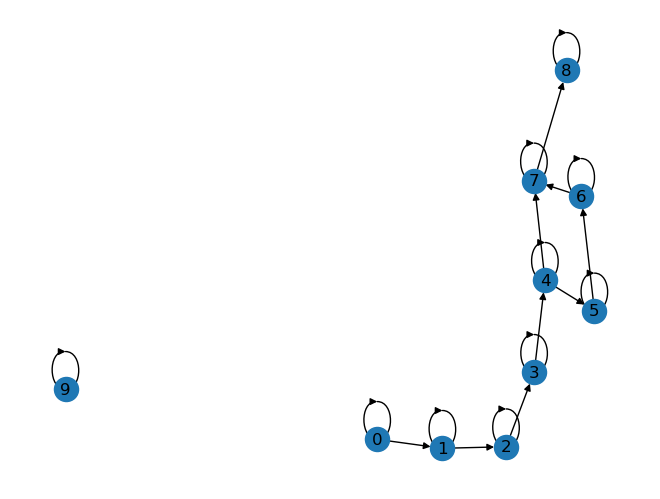

tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
Graph(num_nodes=10, num_edges=19,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


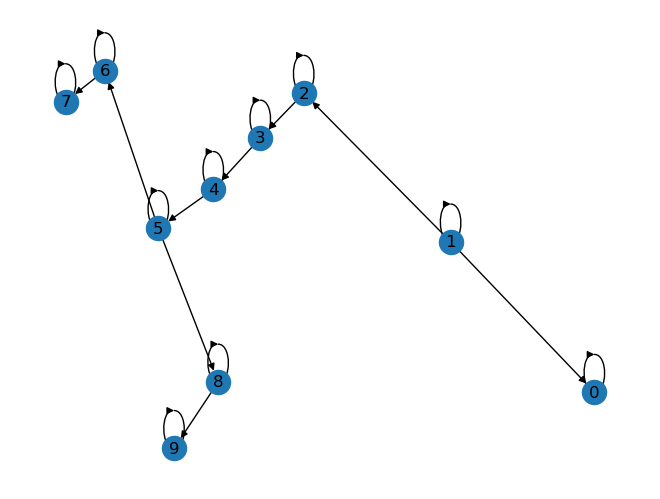

tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Graph(num_nodes=10, num_edges=18,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


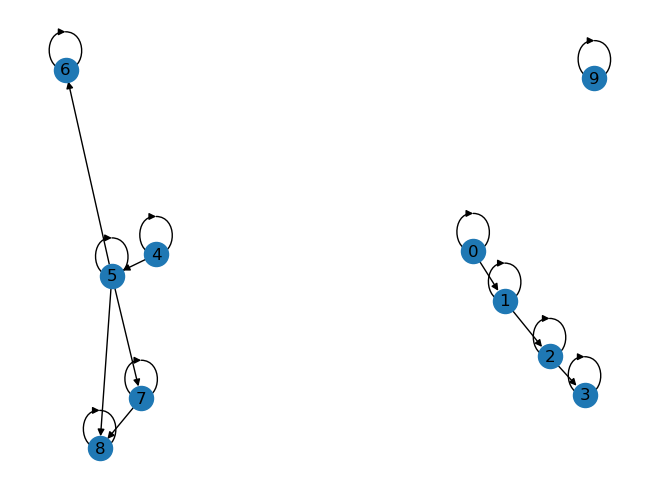

tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
Graph(num_nodes=10, num_edges=17,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


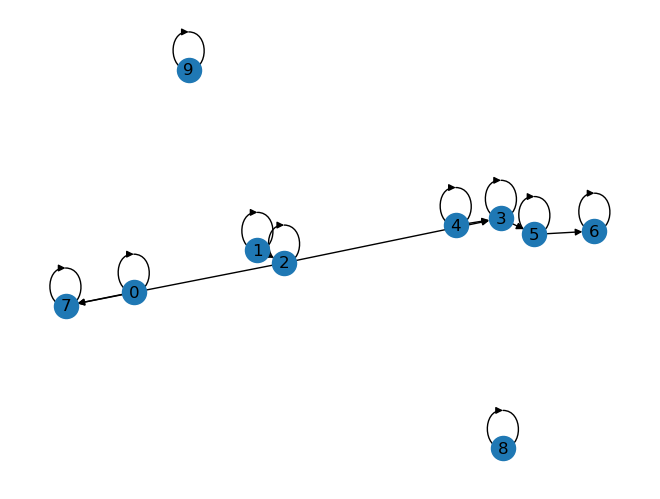

tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
Graph(num_nodes=10, num_edges=16,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


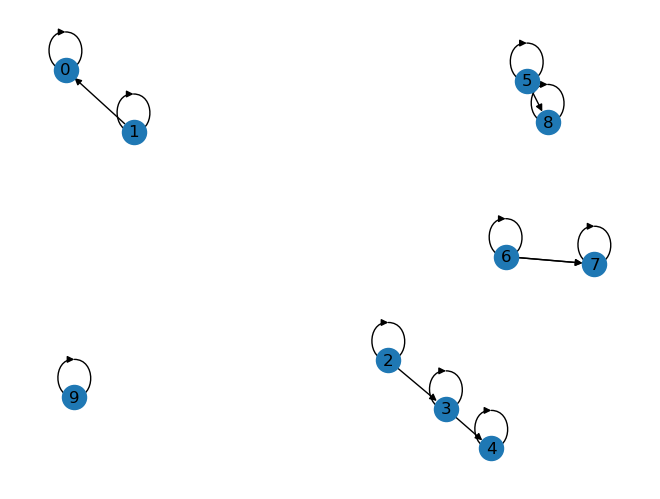

tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
Graph(num_nodes=10, num_edges=10,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


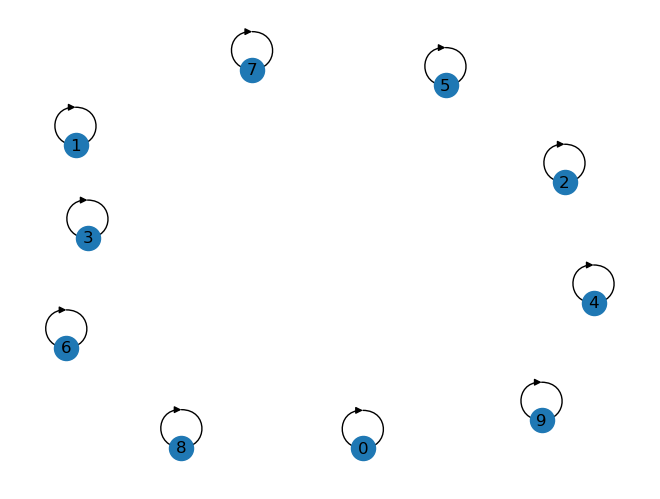

tensor([60, 61, 62, 63, 64, 65, 66, 67])
Graph(num_nodes=8, num_edges=8,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


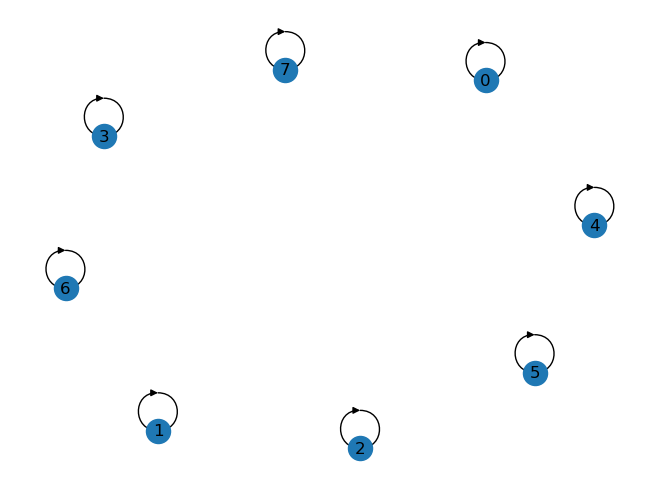

[INFO] Number of Batches: 7


In [24]:
n_batches = 0
for inp, tgt, blocks in graphloader:
    n_batches += 1
    print(tgt)
    G_block1 = dgl.node_subgraph(G, tgt)
    print(G_block1)
    nx.draw(dgl.to_networkx(G_block1), with_labels = True)
    plt.show()
print("[INFO] Number of Batches: %d" %(n_batches))

In [6]:
inp

tensor([60, 61, 62, 63, 64, 65, 66, 67, 28, 30, 31, 35, 36, 40, 41, 51, 25, 27,
         0, 29,  8, 33, 48, 49])

In [7]:
tgt

tensor([60, 61, 62, 63, 64, 65, 66, 67])

In [26]:
blocks[0]

Block(num_src_nodes=24, num_dst_nodes=16, num_edges=37)

In [32]:
blocks[1]

Block(num_src_nodes=16, num_dst_nodes=8, num_edges=16)

In [31]:
dgl.block_to_graph(blocks[0])

Graph(num_nodes={'_N_src': 24, '_N_dst': 16},
      num_edges={('_N_src', '_E', '_N_dst'): 37},
      metagraph=[('_N_src', '_N_dst', '_E')])

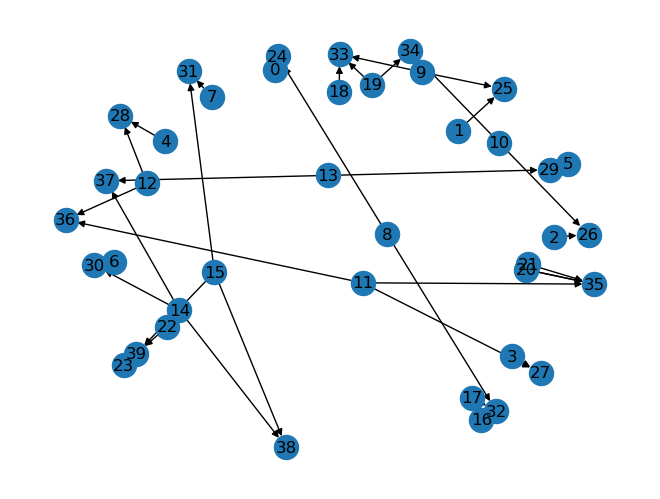

In [30]:
nx.draw(dgl.to_networkx(dgl.to_homogeneous(dgl.block_to_graph(blocks[0]))), with_labels = True)

In [28]:
dgl.block_to_graph(blocks[0])

Graph(num_nodes={'_N_src': 24, '_N_dst': 16},
      num_edges={('_N_src', '_E', '_N_dst'): 37},
      metagraph=[('_N_src', '_N_dst', '_E')])

In [11]:
dgl.block_to_graph(blocks[1])

Graph(num_nodes={'_N_src': 16, '_N_dst': 8},
      num_edges={('_N_src', '_E', '_N_dst'): 8},
      metagraph=[('_N_src', '_N_dst', '_E')])